In [4]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [52]:
import configparser
import psycopg2
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [6]:
#read config file
config = configparser.ConfigParser()
config.read('dwh.cfg')

#connect to the host
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
#cur = conn.cursor()
print(conn)

<connection object at 0x7f6792a11508; dsn: 'user=awsuser password=xxx dbname=dev host=redshift-cluster-1.czgion4wm3xo.us-east-1.redshift.amazonaws.com port=5439', closed: 0>


In [17]:
#count songs
df_song = pd.read_sql("SELECT  COUNT(*) FROM song;", conn)
df_song

,count
0,14896


In [47]:
df_song = pd.read_sql("SELECT * FROM song;", conn)
df_song.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14896 entries, 0 to 14895
Data columns (total 5 columns):
song_id      14896 non-null object
title        14896 non-null object
artist_id    14896 non-null object
year         14896 non-null int64
duration     14896 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 582.0+ KB


In [16]:
#number of artists
df_artist = pd.read_sql("SELECT  COUNT(*) FROM artist;", conn)
df_artist

,count
0,10025


In [61]:
df_artist = pd.read_sql("SELECT * FROM artist;", conn)
df_artist.head()

,artist_id,name,location,artist_latitude,artist_longitude
0,AR00DG71187B9B7FCB,Basslovers United,None,NaN,NaN
1,AR00YYQ1187FB504DC,God Is My Co-Pilot,"New York, NY",40.71455,-74.00712
2,AR01IP11187B9AF5D2,Call To Preserve,"Rockledge, Florida",28.33268,-80.73486
3,AR01SCU1187B9A693C,Street Dogs,"Boston, MA",NaN,NaN
4,AR02LMQ1187B992AC9,The Classic Crime,"Seattle, WA",47.60356,-122.32944


In [20]:
df_songplays = pd.read_sql("SELECT * FROM songplays;", conn)

In [21]:
#first 5 rows of songplays table
df_songplays.head()

,songplay_id,start_time,user_id,level,song_id,artist_id,session_id,location,user_agent
0,179,2018-11-01 21:11:13,8,free,SOEIQUY12AF72A086A,ARHUC691187B9AD27F,139,"Phoenix-Mesa-Scottsdale, AZ","""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK..."
1,115,2018-11-02 17:31:45,10,free,SOHTKMO12AB01843B0,AR5EYTL1187B98EDA0,182,"Washington-Arlington-Alexandria, DC-VA-MD-WV","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4..."
2,112,2018-11-03 17:59:01,15,paid,SOHTKMO12AB01843B0,AR5EYTL1187B98EDA0,199,"Chicago-Naperville-Elgin, IL-IN-WI","""Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/5..."
3,174,2018-11-03 19:33:39,95,paid,SOYTFSY12A6D4FD84E,ARRFSMX1187FB39B03,152,"Winston-Salem, NC","""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like..."
4,2,2018-11-04 16:25:54,69,free,SOARUPP12AB01842E0,ARD46C811C8A414F3F,235,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4..."


In [110]:
#join tables
df_new_songplay = pd.read_sql("SELECT sp.songplay_id, sp.user_id, sp.level, sp.song_id, sp.artist_id, sp.location, s.title,  duration, s.year, art.name \
                              FROM songplays as sp \
                              JOIN song as s ON (sp.song_id = s.song_id) \
                              JOIN artist as art ON (sp.artist_id = art.artist_id)", conn)
df_new_songplay.head()

,songplay_id,user_id,level,song_id,artist_id,location,title,duration,year,name
0,119,88,paid,SOGPESA12AB0180D65,AR1K7TQ11C8A414EC8,"Sacramento--Roseville--Arden-Arcade, CA",Bang! Bang!,200.25424,2008,The Knux
1,156,97,paid,SOHZDYL12A8C141C73,AR32RXI1187B9BA168,"Lansing-East Lansing, MI",My Perfect Cousin,156.36853,1980,The Undertones
2,11,44,paid,SOZARNI12A67020744,AR3WLE91187B99430A,"Waterloo-Cedar Falls, IA",Everything Changes (Album Version),239.54240,2005,Staind
3,169,97,paid,SOSCHDW12A8C130FD7,AR40GSU1187FB3AA01,"Lansing-East Lansing, MI",Song Sung Blue,172.38159,1972,Neil Diamond
4,70,15,paid,SOZCTXZ12AB0182364,AR5KOSW1187FB35FF4,"Chicago-Naperville-Elgin, IL-IN-WI",Setanta matins,269.58322,0,Elena


In [120]:
# songs played by a particular user
df_usersong = pd.read_sql("SELECT title FROM song as s \
                              JOIN songplays as sp ON (sp.song_id = s.song_id) \
                              WHERE user_id = 15 ", conn)

usertitle = df_usersong['title'].value_counts()
usertitle

You're The One                                          3
Mise En Bouche                                          1
Setanta matins                                          1
Given Up (Album Version)                                1
Catch You Baby (Steve Pitron & Max Sanna Radio Edit)    1
Affliction                                              1
All Of This                                             1
Ring My Bell                                            1
Missing (Live in Europe)                                1
Nuff Fire                                               1
Punk Rock Girl                                          1
Planet Caravan (Remastered LP Version)                  1
Nothin' On You [feat. Bruno Mars] (Album Version)       1
Name: title, dtype: int64

In [24]:
#songs levels: paid or free
df_songplays['level'].value_counts()

paid    271
free     62
Name: level, dtype: int64

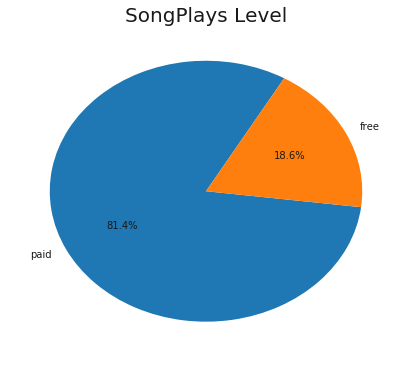

In [86]:
#visualize levels
labels = 'paid', 'free'
plt.subplots(figsize=(7,6))
sorted_counts = df_songplays['level'].value_counts()
plt.title('SongPlays Level', fontsize=(20))
plt.pie(sorted_counts ,labels= labels,autopct='%1.1f%%',startangle=60)
plt.show()

In [99]:
title = df_new_songplay['title'].value_counts()

Text(0.5,1,'Top 10 Songs')

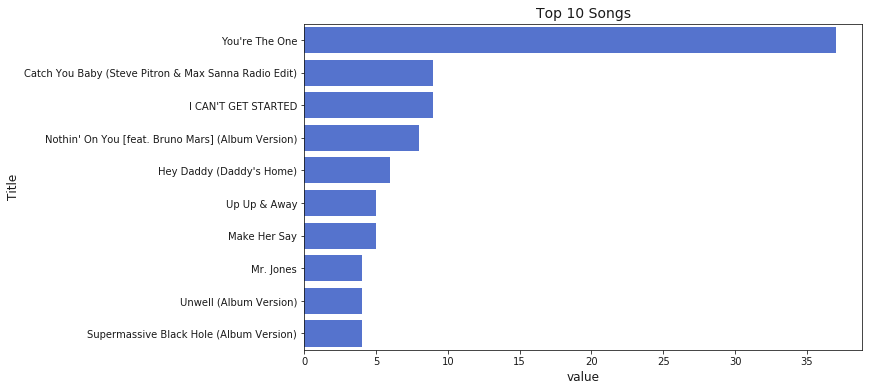

In [100]:
#top songs 
plt.subplots(figsize=(10,6))
sns.barplot(x=title[:10], y = title.index[:10], color = '#4169e1')
plt.xlabel('value', fontsize=(12))
plt.ylabel('Title', fontsize=(12))
plt.title('Top 10 Songs', fontsize=(14))

In [103]:
artist = df_new_songplay['name'].value_counts()

Text(0.5,1,'Top 5 Artists')

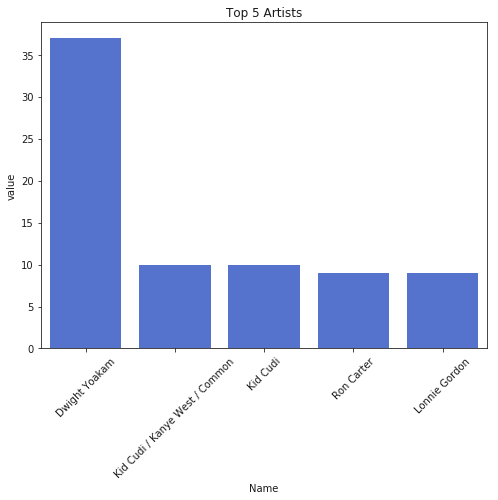

In [107]:
#top artists
plt.subplots(figsize=(8,6))
sns.barplot(x=artist.index[:5], y = artist[:5], color = '#4169e1')
plt.xlabel('Name', fontsize=(10))
plt.ylabel('value', fontsize=(10))
plt.xticks(rotation=45)
plt.title('Top 5 Artists', fontsize=(12))